<a href="https://colab.research.google.com/github/azfarkhoja305/GANs/blob/main/notebooks/Evaluate_TransGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [1]:
# Check GPU
!nvidia-smi

Fri Apr 23 03:35:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    41W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys
import pdb
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import animation, rc
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

# from torchsummary import summary
from types import SimpleNamespace
import json

In [3]:
!git clone --single-branch --branch main https://github.com/azfarkhoja305/GANs.git
!git -C GANs/ pull

fatal: destination path 'GANs' already exists and is not an empty directory.
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/azfarkhoja305/GANs
   73b0bfe..02dfbf3  main       -> origin/main
Updating 73b0bfe..02dfbf3
Fast-forward
 notebooks/TransGAN_CIFAR.ipynb | 40363 +--------------------------------------
 1 file changed, 631 insertions(+), 39732 deletions(-)


In [4]:
Path.ls = lambda x: list(x.iterdir())
if Path('./GANs').exists():
    sys.path.insert(0,'./GANs')

In [5]:
from models.transformer_generator import TGenerator
from models.ViT_discriminator import Discriminator
from metrics.torch_is_fid_score import is_fid_from_generator
from utils.utils import check_gpu, display_images, set_seed, load_params
from utils.checkpoint import Checkpoint
from utils.loss import wgangp_eps_loss
from utils.datasets import ImageDataset
%load_ext autoreload
%autoreload 2

In [6]:
from google.colab import drive
drive.mount('/content/drive')
gdrive = Path('drive/MyDrive')
# gdrive = Path('C:\\GANs\\')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# seed notebook
set_seed(seed=123)
device = check_gpu()
print(f'Using device: {device}')

Using device: cuda


In [8]:
# !set PYTHONPATH=%PYTHONPATH%;C:/GitHub/GANs && python ./scripts/create_fid_stats.py -d cifar_10 -t False
!PYTHONPATH=./GANs/ python GANs/scripts/create_fid_stats.py -d cifar_10 -t False

Namespace(batch_size=256, dataset='cifar_10', save='fid_stats', train='False')
Files already downloaded and verified


# Inference

In [9]:
gen_batch_sz = 64
dis_batch_sz = 32
latent_dims = 1024
lr, beta1, beta2 = 1e-4, 0, 0.999

In [10]:
# Add Horizontal Flip by default
tfms = [transforms.RandomHorizontalFlip()]
dataset =  ImageDataset('cifar_10', batch_sz=dis_batch_sz, tfms=tfms, 
                        num_workers=2, drop_last=True)
# display_images(dataset.train_loader)

Files already downloaded and verified


In [11]:
Gen = TGenerator(latent_dims=latent_dims).to(device)
fixed_z = torch.randn(gen_batch_sz, latent_dims, device=device)
# summary(Gen,(latent_dims,))

In [12]:
args = SimpleNamespace(**{"d_depth": 7, "df_dim": 384, "img_size": 32, "patch_size": 8})
Dis = Discriminator(args).to(device)
# summary(Dis,(3,32,32,))

In [13]:
optG = optim.AdamW(Gen.parameters(), lr=lr, betas=(beta1, beta2))
optD = optim.AdamW(Dis.parameters(), lr=lr, betas=(beta1, beta2))

In [14]:
with open('GANs/results.json') as fp:
  results = json.load(fp)

In [15]:
def compute_is_fid(exp, generator):
    inception_score, fid = is_fid_from_generator(generator=generator,
                                                latent_dims=latent_dims,
                                                num_imgs=10000,
                                                batch_sz=64,
                                                fid_stat_path = stat_path)
    print(f"{exp}: fid = {fid}")
    results[exp]['iss'].append(inception_score)
    results[exp]['fids'].append(fid)
    results[exp]['epochs'].append(epoch)

In [17]:
stat_path = Path('fid_stats/cifar_10_valid_fid_stats.npz')
experiments = ['no_aug', 'flip_lr', 'full_aug', 'co_training', "attn_init", "full_v2", "full_v2_moving_avg"]

for exp in experiments:
  ckp_folder = gdrive/exp
  for filename in os.listdir(ckp_folder):
      if exp not in results:
          results[exp] = {'epochs':[],'iss':[],'fids':[]}
      epoch = int(filename[:-4].split('_')[-1])
      if epoch not in results[exp]['epochs']:
      
          Gen, gen_avg_param, Dis, optG, optD, start_epoch, step, old_logs = \
              Checkpoint.load_checkpoint(ckp_folder/filename, Gen, Dis, optG, optD)
          assert start_epoch > 0
          
          compute_is_fid(exp, Gen)
          if gen_avg_param is not None:
              load_params(Gen, gen_avg_param)
              compute_is_fid(exp + "_AVG", Gen)

          with open('GANs/results.json', 'w') as fp:
              json.dump(results, fp, indent=4, sort_keys=True)

=> Loading checkpoint: drive/MyDrive/full_v2_moving_avg/GanModel_320.pth


full_v2_moving_avg: fid = 42.89776611328125


full_v2_moving_avg_AVG: fid = 36.167510986328125
=> Loading checkpoint: drive/MyDrive/full_v2_moving_avg/GanModel_325.pth


KeyboardInterrupt: ignored

# Analysis

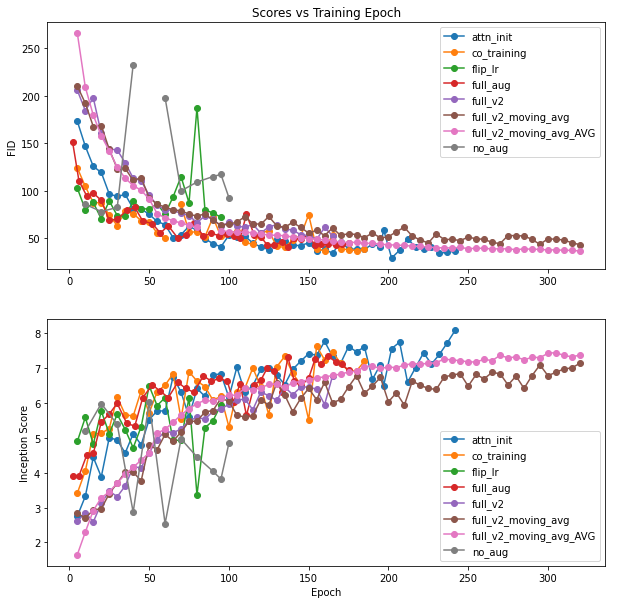

In [18]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

for idx, exp in enumerate(results.keys()):
  e = results[exp]['epochs']
  fid = results[exp]['fids']
  inception_score = results[exp]['iss']
  score = [s[0] for s in inception_score]

  axs[0].plot(e,fid,'-o',label=exp)
  axs[1].plot(e,score,'-o', label=exp)

axs[0].set_ylabel('FID')
axs[1].set_ylabel('Inception Score')

plt.title('Scores vs Training Epoch')
plt.xlabel("Epoch")

axs[0].legend()
axs[1].legend()
plt.show()

In [19]:
from tabulate import tabulate
table = []
for exp in results.keys():
  inception_score = [s[0] for s in results[exp]['iss']]
  table.append([exp,max(results[exp]['epochs']),results[exp]['epochs'][np.nanargmin(results[exp]['fids'])], min(results[exp]['fids']), results[exp]['epochs'][np.nanargmax(inception_score)], max(inception_score)])

print(tabulate(table, headers=["Experiment","Training Epochs","Min FID Epoch", "Min FID", "Max IS Epoch", "Max IS"]))

Experiment                Training Epochs    Min FID Epoch    Min FID    Max IS Epoch    Max IS
----------------------  -----------------  ---------------  ---------  --------------  --------
attn_init                             242              202    28.7528             242   8.08049
co_training                           185              160    36.1584             155   7.6132
flip_lr                                95               20    69.9796              50   6.48188
full_aug                              175              137    40.784              162   7.3485
full_v2                               165              155    48.4732             165   6.77009
full_v2_moving_avg                    320              320    42.8978             320   7.12636
full_v2_moving_avg_AVG                320              320    36.1675             305   7.43338
no_aug                                100               20    77.8442              50   6.01709
